In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import os

In [9]:
data_dir = "/home/joshua_ml/ml/kaggle/fruit_image"
print(os.getcwd())

/home/joshua_ml/ml


In [10]:
batch_size = 8
img_height = 360
img_width = 360

In [11]:
train_ml = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ml = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 360 files belonging to 9 classes.
Using 288 files for training.
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [13]:
# Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(
            "horizontal",
            input_shape=(
                img_height,
                img_width,
                3
            )
        ),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ]
)

2024-10-05 17:33:22.337977: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


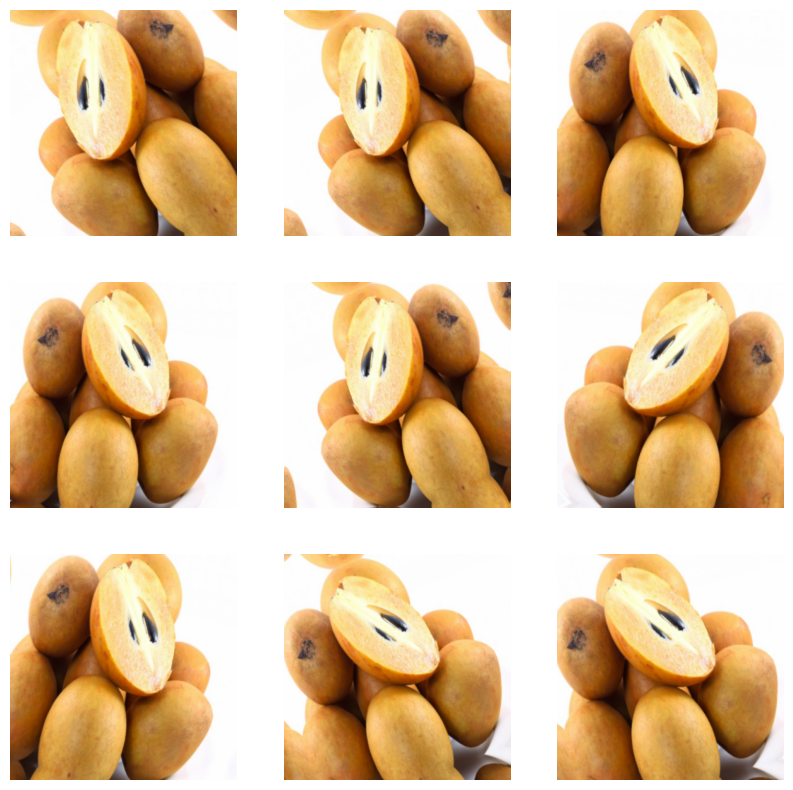

In [15]:
class_names = train_ml.class_names

plt.figure(figsize=(10, 10))
for images, _ in train_ml.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ml:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 360, 360, 3)
(8,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ml = train_ml.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ml = val_ml.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ml = train_ml.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ml))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

2024-10-05 17:33:33.998898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [19]:
# Model
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 360, 360, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 360, 360, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 360, 360, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,613,673 (63.38 MB)

 Trainable params: 16,613,673 (63.38 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Training model
epochs=30
history=model.fit(
    train_ml,
    validation_data=val_ml,
    epochs=epochs
)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8473 - loss: 0.3853 - val_accuracy: 0.5278 - val_loss: 2.7516
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8610 - loss: 0.4535 - val_accuracy: 0.5694 - val_loss: 1.7121
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8750 - loss: 0.4586 - val_accuracy: 0.5694 - val_loss: 2.1786
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8469 - loss: 0.4181 - val_accuracy: 0.5556 - val_loss: 2.2935
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8459 - loss: 0.3900 - val_accuracy: 0.5833 - val_loss: 2.0491
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8803 - loss: 0.3643 - val_accuracy: 0.5833 - val_loss: 2.0065
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9213 - loss: 0.2758 - val_accuracy: 0.5833 - val_loss: 1.9910
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9070 - loss: 0.2515 - val_accuracy: 0.5833 - v

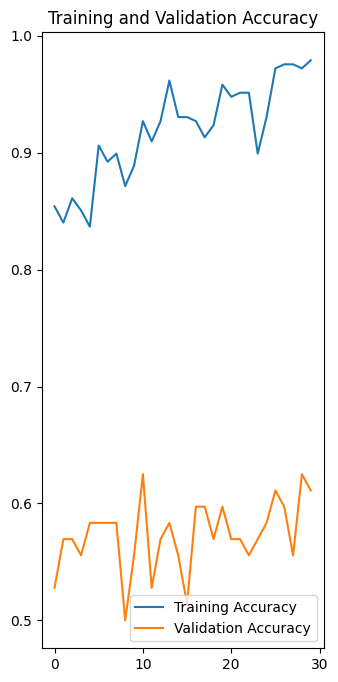

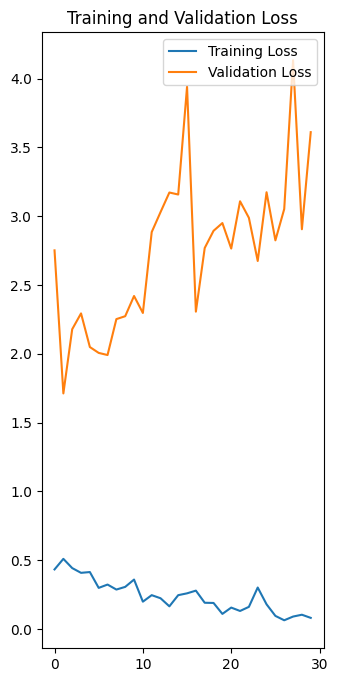

In [29]:
# Visualize
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# Predict
fruit_path = "/home/joshua_ml/ml/kaggle/fruit_image2/train/train/Apple Braeburn/Apple Braeburn_0.jpg"

img = tf.keras.utils.load_img(
    fruit_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image belongs to {} with a confidence ratin of {:.2f} percent"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image belongs to apple_fruit with a confidence ratin of 98.97 percent
